In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error , mean_absolute_error
import datetime
import operator
plt.style.use('fivethirtyeight')
%matplotlib inline

In [15]:
# SIR model

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [16]:
START_DATE = {
    'Italy' : '1/31/20',
    'India' : '1/30/20'
}
class Learner(object):
    def __init__(self, country, loss, start_date='1/22/20', predict_range=150, s_0=100000, i_0=2, r_0=10):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        
        
    def load_confirmed(self, country):
        df = pd.read_csv(r'C:\Users\lenovo10-07-2015\Desktop\Major 2020\MAJOR-2 CORONAVIRUS\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv')
        df = df.drop(['Province/State'], axis=1)
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    
    
    def load_recovered(self, country):
        df = pd.read_csv(r'C:\Users\lenovo10-07-2015\Desktop\Major 2020\MAJOR-2 CORONAVIRUS\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_recovered_global.csv')
        df = df.drop(['Province/State'], axis=1) 
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    
    def load_dead(self, country):
        df = pd.read_csv(r'C:\Users\lenovo10-07-2015\Desktop\Major 2020\MAJOR-2 CORONAVIRUS\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_global.csv')
        df = df.drop(['Province/State'], axis=1) 
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    
    def extend_index(self, index, new_size):
        values= index.values
        current= datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
            return values
        
    def predict(self, beta, gamma, data, recovered, death, country, s_0,i_0,r_0):
        
        new_index= self.extend_index(data.index, self.predict_range)
        size= len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return (new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size,1)))
    
    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(loss, [0.001, 0.001], args = (data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds = [(0.000001, 0.4), (0.000001, 0.4)])
        
        print(optimal)
        
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data,recovered,death,self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected Data' : extended_actual, 'Recovered Data' : extended_recovered, 'Death Data' : extended_death, 'Susceptible' : prediction.y[0], 'Infected' : prediction.y[1], 'Recovered' : prediction.y[2]}, index = new_index)
        
        df.to_csv(f"{self.country}.csv")
        fig, ax = plt.subplots(figsize = (15,10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta: .8f}, gamma={gamma: .8f}, r_0:{(beta/gamma) : .8f}")
        fig.savefig(f"{self.country}.png")
        return df, fig
        

In [17]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0,size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * 11 + (1-alpha) *12

      fun: 11.9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([0.001, 0.001])
country=India, beta= 0.00100000, gamma= 0.00100000, r_0: 1.00000000


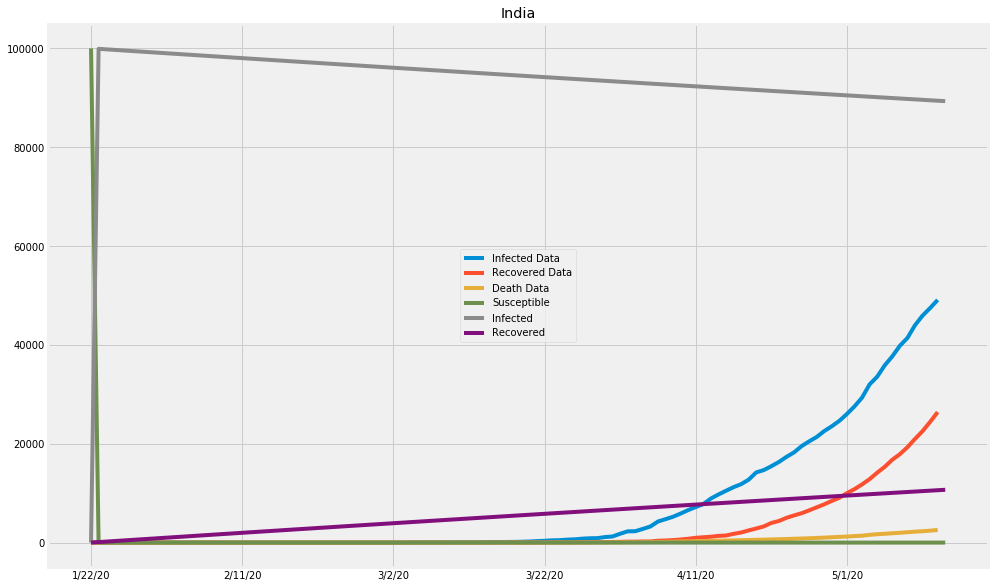

In [18]:
india_learner=Learner(country="India", loss=loss, i_0=3)
india_sir, india_sir_fig = india_learner.train()

In [19]:
italy_learner=Learner(country="Italy", loss= loss)

      fun: 11.9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([0.001, 0.001])
country=Italy, beta= 0.00100000, gamma= 0.00100000, r_0: 1.00000000


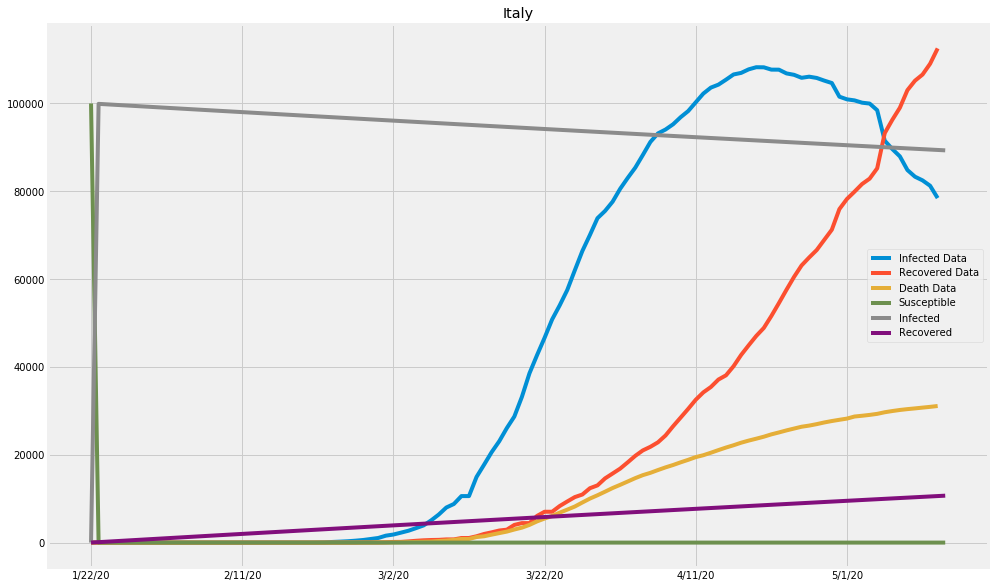

In [20]:
italy_df, italy_fig = italy_learner.train()